# Analysing New York City High School Data

This project will use the following datasets all focused on New York City High School data:

- `ap_2010.csv` - Data on [AP](https://en.wikipedia.org/wiki/Advanced_Placement_exams) test results
- `class_size.csv` - Data on class sizes
- `demographics` - Data on demogrpahics
- `graduation.csv` - Data on graduate outcomes
- `hs_directory.csv` - A directory of high schools
- `sat_results.csv` - Data on SAT scores
- `survey_all.txt` - Results from surveys conducted in all NYC schools
- `survey_d75.txt` - Results from surveys in NYC district 75 schools

The aim of this project is to:

- Explore correlation between survey results and SAT scores
- Visualise safety scores by district
- Explore the relationship between ethnicity and SAT scores
- Explore the relationship between gender and SAT scores
- Explore the relationship between AP and SAT scores
- Investiate class size and SAT scores

# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv(r"C:\Users\George Boorman\Dropbox\Dataquest\Files\Guided Project 7 - Analyzing NYC High School Data/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv(r"C:\Users\George Boorman\Dropbox\Dataquest\Files\Guided Project 7 - Analyzing NYC High School Data/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv(r"C:\Users\George Boorman\Dropbox\Dataquest\Files\Guided Project 7 - Analyzing NYC High School Data/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Adding a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [25]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
Census Tract                       0.048737
BIN                                0.052232
BBL                                0.044427
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 85, dtype: float64


# Plotting survey correlations

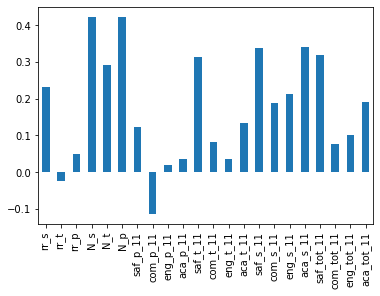

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")
import matplotlib.pyplot as plt
%matplotlib inline
combined.corr()['sat_score'][survey_fields].plot.bar()

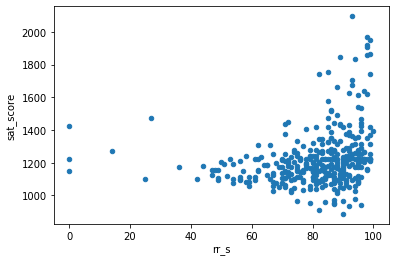

In [11]:
combined.plot(x='rr_s', y='sat_score', kind='scatter')
plt.show()

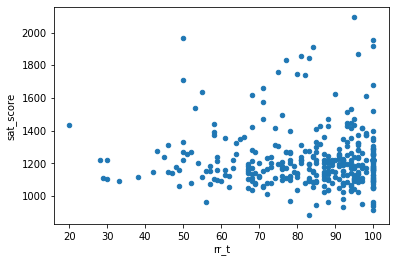

In [12]:
combined.plot(x='rr_t', y='sat_score', kind='scatter')
plt.show()

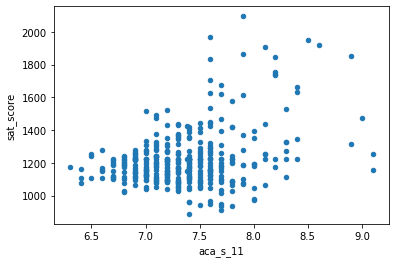

In [13]:
combined.plot(x='aca_s_11', y='sat_score', kind='scatter')
plt.show()

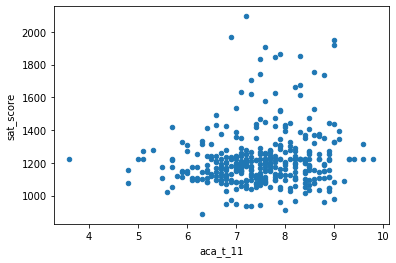

In [14]:
combined.plot(x='aca_t_11', y='sat_score', kind='scatter')
plt.show()

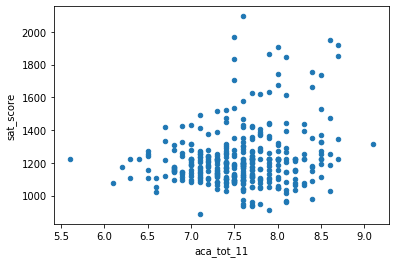

In [15]:
combined.plot(x='aca_tot_11', y='sat_score', kind='scatter')
plt.show()

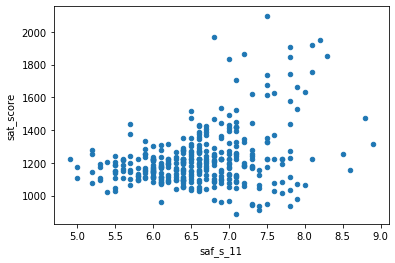

In [16]:
combined.plot(x='saf_s_11', y='sat_score', kind='scatter')
plt.show()

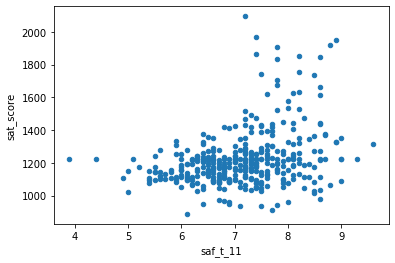

In [17]:
combined.plot(x='saf_t_11', y='sat_score', kind='scatter')
plt.show()

From the plots above we can see strong correlations between SAT scores and:
- aca_s_11 (Academic expectations based on students' responses to survey)
- aca_t_11 (Academic expectations based on teachers' responses to survey)
- saf_s_11 (Safety and Respect score based on students' responses to survey)
- saf_t_11 (Safety and Respect score based on teachers' responses to survey)

# Exploring safety scores

In [18]:
#Compute the average safety score for each district
district_safety = combined.groupby('school_dist').agg(numpy.mean)
district_safety.agg('saf_t_11')

school_dist
01    7.066667
02    7.404167
03    6.675000
04    7.871429
05    6.857143
06    7.490000
07    6.969231
08    7.109091
09    6.935000
10    6.972727
11    7.026667
12    7.266667
13    7.092308
14    7.271429
15    6.566667
16    5.750000
17    6.957143
18    6.890909
19    6.516667
20    7.820000
21    7.072727
22    8.175000
23    7.033333
24    7.669231
25    7.487500
26    7.000000
27    6.930000
28    7.600000
29    7.050000
30    7.500000
31    7.210000
32    7.050000
Name: saf_t_11, dtype: float64

C:\Users\George Boorman\anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
C:\Users\George Boorman\anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]


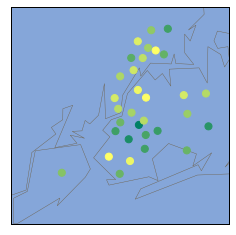

In [19]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = district_safety['lon'].tolist()
latitudes = district_safety['lat'].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True,
         c=district_safety['saf_s_11'], cmap='summer')
plt.show()

By aggregating data by school district, computing the average safety score of each district and visualising on a map we can observe the following:
- Safety scores, as reported by students, appear lower for many districts in central parts of Brooklyn (exceptions in Bay Ridge, Sheepshead Bay and Woodside) compared to Manhattan, Staten Island and Queens

# Exploring Ethnicity and SAT scores

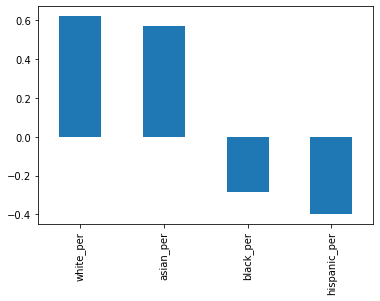

In [20]:
ethnicity_columns = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr()['sat_score'][ethnicity_columns].plot.bar()

The bar plot above shows the following:
- a strong positive correlation between the number of White students and SAT scores
- a strong positive correlation between the number of Asian students and SAT scores
- a weak negative correlation between the number of Black students and SAT scores
- a moderate negative correlation between the number of Hispanic students and SAT scores

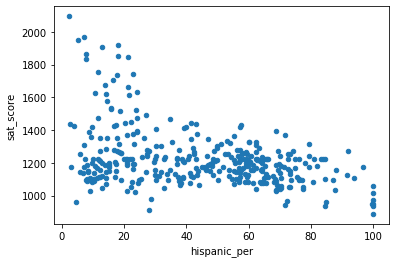

In [21]:
combined.plot(x='hispanic_per', y='sat_score', kind='scatter')

By inspecting the correlation between hispanic_per and sat_scores further, we can see there is a cluster of schools with hispanic_per of approximately 100 and these are associated with low SAT scores (less than 1100). 
We can also see schools with hispanic_per below 30 achieving much higher average sat_score versus schools with higher hispanic_per. 
Let's find out more about the schools in the upper and lower thresholds, specifically:
- hispanic_per of greater than 95%
- hispanic_per of less than 10% and av

In [22]:
high_hispanic_per = combined[combined['hispanic_per'] > 95]
low_hispanic_high_sat = combined[combined['hispanic_per'] < 10] 
low_hispanic_high_sat = low_hispanic_high_sat[low_hispanic_high_sat['sat_score'] > 1800]
low_hispanic_high_sat

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.0,2819.0,...,"345 Chambers Street\nNew York, NY 10282\n(40.7...",1.0,1.0,31703.0,1084587.0,1.000160e+09,Battery Park City-Lower Manhattan ...,40.717746,-74.014049,02
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.0,2435.0,...,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",7.0,11.0,409.0,2094706.0,2.032510e+09,Van Cortlandt Village ...,40.877056,-73.889780,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.0,3692.0,...,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",2.0,35.0,33.0,3058752.0,3.020980e+09,Fort Greene ...,40.688107,-73.976745,13
327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,121,612.0,660.0,596.0,1868.0,Queens HS for Science York Colllege,215.0,338.0,...,"94 50 159 Street\nJamaica, NY 11433\n(40.70099...",12.0,27.0,246.0,4215611.0,4.100990e+09,Jamaica ...,40.700999,-73.798154,28
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635.0,682.0,636.0,1953.0,STATEN ISLAND TECHNICAL HS,528.0,905.0,...,485 Clawson Street Staten Island\nNY 10306\n(4...,2.0,50.0,134.0,5107621.0,5.042440e+09,New Dorp-Midland Beach ...,40.567913,-74.115362,31


From limited further research on the above schools, the following observations can be made:
- All 5 schools make admissions based on applicants' scores in the [Specialised High School Admissions Test](https://en.wikipedia.org/wiki/Specialized_High_Schools_Admissions_Test)
- 3 of these, Stuyvesant High School, Bronx High School of Science and Brooklyn Technical High School, are categorised as the original specialised schools operated by the New York City Department of Education
- Stuyvesant High School has had a history of [alleged institional racism](https://en.wikipedia.org/wiki/Stuyvesant_High_School#Demographics_and_alleged_discrimination) in their admissions processes 

In [27]:
pd.options.display.max_columns = None
high_hispanic_per

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,postcode,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,59.00,Total Cohort,MANHATTAN BRIDGES HIGH SCHOOL,2006,111.000000,77,69.400000,63,56.800000,81.800000,16,14.400000,20.800000,47,42.300000,61.000000,14,12.600000,18.200000,17,15.300000,15,13.500000,2,107.187500,4.375000,23.475000,19.187500,26.937500,0.0,MANHATTAN BRIDGES HIGH SCHOOL,20112012,0.0,83.5,541,,,,,,,,,,,149,168,138,86,393.0,72.6,9.0,1.7,0,5,1,0.2,0,0.0,540,99.8,0,0.0,278.0,51.4,263.0,48.6,94.0,100,83,480.0,37.0,396.0,8.8,8.2,7.6,8.4,7.6,6.6,7.5,8.2,7.2,6.2,6.7,7.5,7.9,7.0,7.3,8.0,02M542,Manhattan Bridges High School,Manhattan,M535,212-757-5274,212-757-5411,9.0,12,0.0,12.0,"M104, M11, M31, M34A-SBS, M42, M50, M57","C, E to 50th St",525 West 50Th Street,New York,NY,10019,manhattanbridges.org,552.0,Park West Educational Campus,0,We are a New Visions School founded on the bel...,"College Now, National Academy Foundation, Acad...",Spanish,"Calculus AB, English Language and Composition,...",0,0,"Academic Intervention Services (Extended Day),...","Baseball, Bowling, Handball, Soccer, Tennis, V...","Baseball, Bowling, Handball, Soccer, Tennis, V...","Bowling, Tennis","Running Club, Workout Club",The Young Men and Women Hebrew Association (YM...,"St. Vincent's Hospital, New York-Presbyterian ...","Cornell University, Columbia University, Roche...","El Museo del Barrio, Carnegie Hall, Metropolit...","New Visions for Public Schools, National Acade...","Latin Vision Media, Urban Latino Magazine Inc....","Chase Manhattan Bank, Bank of America","Manhattan District Attorney's Office, New York...","Dress Code Required: white shirt/blouse, black...","Community Service Requirement, Extended Day Pr...",8:00 AM,

With the exception of Washington Heights Expeditionary Learning School, all schools with a hispanic student population of more than 95% are made up of a substantial proportion of English Language Learners (ell) - 72.6% to 94.6%. It is reasonable to expect that as many students are studying English, they may find the SAT test harder than those who are native English speakers - as even the Maths section has been shown to be text heavy and therefore require [ell students to take more time to process the questions](https://www.reuters.com/investigates/special-report/college-sat-redesign/)

# Exploring Gender and SAT scores

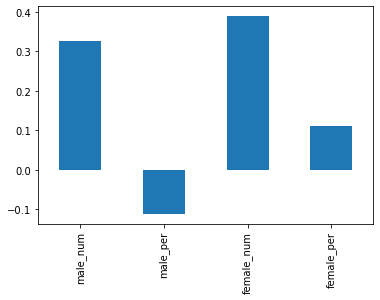

In [29]:
gender_cols = ['male_num', 'male_per', 'female_num', 'female_per']
combined.corr()['sat_score'][gender_cols].plot.bar()

The bar plot shows moderate positive correlations between the SAT scores and a) number of female students, and b) male students.

There doesn't appear to be any correlation between the proportion of either male or female students and SAT scores. Let's investigate further by looking at schools with a higher percentage of female students.

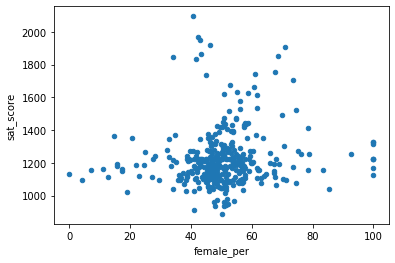

In [40]:
combined.plot('female_per', 'sat_score', 'scatter')

The box plot shows that a high or low proportion of female students has no significant impact on SAT scores.

In [42]:
high_females_per = combined[combined['female_per'] > 60]
high_females_high_sat = high_females_per[high_females_per['sat_score'] > 1700]
high_females_high_sat

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,postcode,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,153.45,Total Cohort,BARD HIGH SCHOOL EARLY COLLEGE,2006,139.0,134,96.4,134,96.4,100.0,0,0.0,0.0,134,96.4,100.0,0,0.0,0.0,4,2.9,1,0.7,1,214.166667,10.250000,20.975000,17.166667,24.250000,0.0,BARD HIGH SCHOOL EARLY COLLEGE,20112012,0.0,18.0,617,,,,,,,,,,,184,162,128,143,1.0,0.2,5.0,0.8,0,0,93,15.1,93,15.1,112,18.2,307,49.8,193.0,31.3,424.0,68.7,98.0,81,50,561.0,30.0,283.0,8.8,8.2,8.3,9.1,8.2,7.4,7.5,8.3,8.3,7.3,8.0,8.9,8.5,7.6,8.0,8.7,01M696,Bard High School Early College,Manhattan,M097,212-995-8479,212-777-4702,9.0,12,0.0,12.0,"M14A, M14D, M21, M22, M9",0,525 East Houston Street,New York,NY,10002,www.bard.edu/bhsec,560.0,0,0,Bard High School Early College Manhattan (BHSE...,"In the first two years at BHSEC, students unde...","Chinese (Mandarin), Latin, Spanish",0,0,0,"Bard Bulletin online newspaper, Bardvark stude...","Basketball, Soccer, Tennis, Volleyball","Basketball, Soccer, Tennis, Volleyball",Outdoor Track,Co-ed Ultimate Frisbee,"Lower East Side Girls Club, Third Street Music...",0,"Bard College, Bard College at Simon's Rock, Ro...","American Symphony Orchestra, American Museum o...",0,0,0,New York Academy of Sciences,0,Student Summer Orientation,9:00 AM,3:50 PM,This school will provide students with disabil...,ESL,Not Functionally Accessible,1,Open to New York City residents,0,0,0,0,0,0,0.0,0.0,0.0,"525 East Houston Street\nNew York, NY 10002\n(...",3.0,2.0,1002.0,1004062.0,1.003250e+09,Lower East Side ...,40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,169.00,Total Cohort,ELEANOR ROOSEVELT HIGH SCHOOL,2006,127.0,127,100.0,12

By looking at any schools with a high percentage of female students (more than 60%) and a high average SAT score (greater than 1700), we can see only 5 out of 363 schools meet this criteria. If we drop the SAT criteria we have 53 schools, so less than one tenth of these are performing well on SAT scores. Of those 5, some quick research shows:
- These schools have admissions criteria, therefore seeking students who are performing well academically as evaluated by standardised tests and/or bespoke applications processes
- [Townsend Harris High School](https://en.wikipedia.org/wiki/Townsend_Harris_High_School) is ranked as # 1 school in New York City, with 10,000 applications annually for 270 freshman student admissions
- One school, Bard High School Early College, actually has students sit the [SAT early](https://en.wikipedia.org/wiki/Bard_High_School_Early_College#School_structure) and then take early college programs in 11th and 12th grade

# Exploring AP scores vs SAT scores

In [53]:
pd.options.display.max_rows = None
#calculating the % of students who take an AP exam
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
ap_per_average = ap_per.agg(numpy.mean)
print(ap_per)
print(ap_per_average)

0      0.305756
1      0.098985
2      0.031773
3      0.351577
4      0.158091
5      0.209123
6      0.741545
7      0.297988
8      0.376177
9      0.307945
10     0.050725
11     0.229698
12     0.093126
13     0.080128
14     0.384014
15     0.341346
16     0.260664
17     0.297988
18     0.388641
19     0.424437
20     0.528807
21     0.152798
22     0.039841
23     0.180556
24     0.196891
25     0.295938
26     0.305720
27     0.137380
28     0.306482
29     0.115385
30     0.115321
31     0.737308
32     0.570924
33     0.733118
34     0.097902
35     0.290606
36     0.036923
37     0.457992
38     0.124845
39     0.544426
40     0.061100
41     0.056922
42     0.110497
43     0.594603
44     0.123845
45     0.305033
46     0.172805
47     0.016279
48     0.109836
49     0.043777
50     0.672025
51     0.111588
52     0.062500
53     0.069735
54     0.308681
55     0.352538
56     0.455932
57     0.360416
58     0.125969
59     0.589173
60     0.142857
61     0.265259
62     0

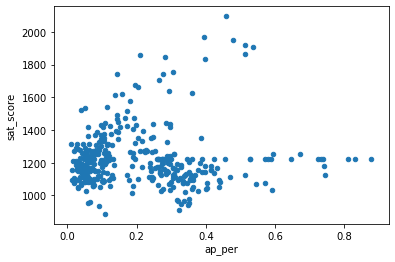

In [54]:
combined.plot('ap_per', 'sat_score', 'scatter')

In [59]:
combined.corr()['sat_score']['ap_per']

0.05717081390766967

In [55]:
high_ap_high_sat = combined[combined['ap_per'] > 0.4]
high_ap_high_sat = high_ap_high_sat[high_ap_high_sat['sat_score'] > 1600]
high_ap_high_sat

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,postcode,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist,ap_per
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.0,2819.0,2648.0,Total Cohort,STUYVESANT HIGH SCHOOL,2006,787.0,774,98.3,774,98.3,100.0,770,97.8,99.5,4,0.5,0.5,0,0.0,0.0,10,1.3,3,0.4,2,876.052632,28.000000,31.115789,24.105263,33.842105,0.0,STUYVESANT HIGH SCHOOL,20112012,0.0,30.3,3297,,,,,,,,,,,813,827,848,809,0.0,0.0,14.0,0.4,0,0,2377,72.1,40,1.2,80,2.4,780,23.7,1956.0,59.3,1341.0,40.7,93.0,95,33,3039.0,161.0,1062.0,8.4,7.5,7.7,7.7,7.2,5.6,6.1,7.2,7.5,6.2,7.0,7.9,7.7,6.4,6.9,7.6,02M475,Stuyvesant High School,Manhattan,M477,212-312-4800,212-587-3874,9.0,12,0.0,12.0,"M20, M22, M5, M9, S1115","1, 2, 3, A, C, E to Chambers St ; R to City Hall",345 Chambers Street,New York,NY,10282,http://stuy.edu,3292.0,0,Specialized School,Our goal is to provide our students with the b...,Mentoring in Intel Science Program through pro...,"Chinese (Mandarin), French, German, Italian, J...","Biology, Calculus AB, Calculus BC, Chemistry, ...",0,0,"Accelerated courses, Student Union, Yearly pub...","Basketball, Bowling, Cross Country, Fencing, G...","Basketball, Bowling, Cross Country, Fencing, G...",Cricket,0,0,"Bellevue Hospital Center, New York-Presbyteria...","New York Law School, New York University (NYU)...",0,"American Red Cross, UNICEF, American Cancer So...",0,"Citicorp, Goldman Sachs",Explorer Program,This is one of New York City's eight (8) Speci...,0,8:00 AM,3:30 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Open to New York City residents,0,0,0,0,0,0,0.0,0.0,0.0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",1.0,1.0,31703.0,1084587.0,1.000160e+09,Battery Park City-Lower Manhattan ...,40.717746,-74.014049,02,0.457992
155,10X696,HIGH SCHOOL OF AMERIC

From the scatter plot we could see there isn't a significant correlation between AP score and SAT score. There was a cluster of schools with above average AP_per (>0.4 compared to a mean across the combined dataset of 0.21) and high SAT scores (>1600). 

When we extracted those schools, we can see some of the same schools identified earlier as high performers. It would be interesting to investigate further as to why no relationship between the two scores exist - some of our potential hypotheses would be:

- Is there an impact on SAT score caused by the number of AP exams taken?
- Do high school admissions processes, through standardised tests, demonstrate a stronger correlation with SAT scores compared to AP scores? 

# Class size and SAT score

In [61]:
combined.corr()['sat_score']['AVERAGE CLASS SIZE']

0.3810143308095523

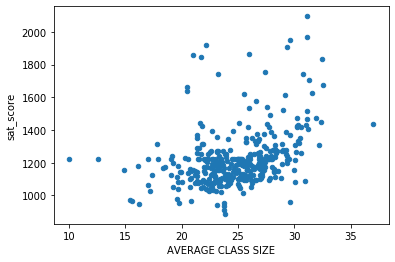

In [64]:
combined.plot('AVERAGE CLASS SIZE', 'sat_score', 'scatter')

In [68]:
combined['AVERAGE CLASS SIZE'].mean()
large_class_high_sat = combined[combined['AVERAGE CLASS SIZE'] > 28]
large_class_high_sat = large_class_high_sat[large_class_high_sat['sat_score'] > 1600]
large_class_high_sat

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,postcode,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist,ap_per
24,02M412,N.Y.C. LAB SCHOOL FOR COLLABORATIVE STUDIES,114,537.0,590.0,550.0,1677.0,NYC LAB HS FOR COLL. STUDIES,114.0,140.0,97.0,Total Cohort,N.Y.C. LAB SCHOOL FOR COLLABORATIVE S,2006,124.0,113,91.1,106,85.5,93.8,62,50.0,54.9,44,35.5,38.9,7,5.6,6.2,9,7.3,2,1.6,2,75.266667,2.333333,32.566667,30.466667,34.466667,0.0,NYC LAB SCHOOL FOR COLLABORATIVE STUDIES,20112012,0.0,21.6,579,,,,,,,,,,,187,127,132,133,9.0,1.6,87.0,15.0,71,0,170,29.4,49,8.5,81,14.0,266,45.9,272.0,47.0,307.0,53.0,93.0,100,45,482.0,34.0,227.0,8.4,8.2,7.9,8.1,7.8,7.7,7.5,8.3,7.5,6.9,7.0,7.7,7.9,7.6,7.5,8.0,02M412,N.Y.C. Lab School for Collaborative Studies,Manhattan,M070,212-691-6119,212-691-2147,9.0,12,0.0,12.0,"M11, M14A, M14D, M20, M23, M5, M7","1 to 18th St ; 2, 3, F, M to 14th St ; A, C, E...",333 West 17 Street,New York,NY,10011,www.nyclabschool.org,599.0,0,0,Collaboration is the key element upon which al...,All classes value and teach skills of social a...,Spanish,"Biology, Calculus AB, Calculus BC, English Lan...",0,0,"Asian Cultural Club, Black Alliance, Chorus, C...","Basketball, Cross Country, Indoor Track, Socce...","Basketball, Cross Country, Indoor Track, Socce...",0,"Girls Flag Football, Bowling, Weight Training,...","Hudson Guild, The Highline, CASALEAP Community...",0,"Teachers College, Bank Street College, Hunter ...","Whitney Museum of American Art,Museum of Moder...",0,0,0,0,0,Community Service Requirement,8:00 AM,2:50 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to District 2 students or residents,Then to Manhattan students or residents,Then to New York City residents,0,0,0,0,0.0,0.0,0.0,"333 West 17 Street\nNew York, NY 10011\n(40.74...",4.0,3.0,83.0,1079152.0,1.007410e+09,Hudson